
# 6-year run: variability in float observations
# compare variability captured by daily vs. 10-daily observations
# metric for "variability": seasonal amplitude (also look at the annual mean)
#
# HERE: plot maps + vertical profiles within biomes 
# Fig. 6 of GMD paper


In [1]:

import sys
sys.path.append('/global/homes/c/cnissen/scripts/seawater-3.3.4/seawater/')
import os
import glob
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
#from seawater import dist
#import seawater as sw
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from numba import njit
import time
from statsmodels.stats.weightstats import DescrStatsW
from tqdm import tqdm
from math import sin, cos, sqrt, atan2, radians

In [2]:
#-----
# saving plots
#-----

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/vertical_profiles_biomes/6year_run/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
savepath2     = savepath+'eps/'
# check existence of paths
if not os.path.exists(savepath2):
    print ('Created '+savepath2)
    os.makedirs(savepath2)
    

In [3]:
#---
# check for negative values in chl field...
#---

path = '/global/cfs/cdirs/m4003/maltrud/6year/monthlyEulerianAverages/'
ff = xr.open_dataset(path+'monthlyAverageEulerianFields.year0060.nc')
diatchl  = ff['timeMonthly_avg_ecosysTracers_diatChl'][:,0,:,5].values
ff.close()

print(diatchl.shape)
#print(diatchl[-1,0,:,0].shape) #.isel(nVertLevels==1,record=12))#

#print(np.min(diatchl[0,0,:,0]))
#print(np.min(np.squeeze(diatchl)[diatchl>-10000]))


(12, 236853)


In [4]:
print(np.min(diatchl[diatchl>-10000]))



0.00012673977


In [5]:
#---
# read mesh info
#---
rad_to_deg = 180.0/np.pi

path_mesh = '/global/cfs/cdirs/m4003/maltrud/'
meshID = 'EC30to60E2r2'
meshfile = xr. open_dataset(path_mesh+'ocean.'+meshID+'.210210.nc')
#print(meshfile)

lon  = meshfile['lonCell'].values*rad_to_deg
lat  = meshfile['latCell'].values*rad_to_deg
topo = meshfile['bottomDepth'].values
area = meshfile['areaCell'].values
zlevs            = meshfile['refBottomDepth'].values
layerThickness   = meshfile['layerThickness'].values
restingThickness = meshfile['restingThickness'].values

print(len(lon),'nodes in mesh')
print(topo.shape)
print(area.shape)
print('Min/Max lon:',np.min(lon),np.max(lon))
print('Min/Max lat:',np.min(lat),np.max(lat))
print('layerThickness.shape:',layerThickness.shape)
print('restingThickness.shape:',restingThickness.shape)

meshfile.close()

# get volume
area3D = np.tile(area,[len(zlevs),1])
print('area3D.shape:',area3D.shape)

volume = np.multiply(area3D,restingThickness.transpose())
print('volume.shape:',volume.shape)


236853 nodes in mesh
(236853,)
(236853,)
Min/Max lon: 0.0007300572350528742 359.997672445938
Min/Max lat: -78.53259417674468 89.94461290099375
layerThickness.shape: (1, 236853, 60)
restingThickness.shape: (236853, 60)
area3D.shape: (60, 236853)
volume.shape: (60, 236853)


In [6]:
#---
# define depth arrays
#---

zlevs0 = np.concatenate(([0],zlevs))
#print(zlevs0)
dz = np.diff(zlevs0)
print (dz)

#dz_3D = np.transpose(np.tile(dz,[no3_all_E3SM_10.shape[0],no3_all_E3SM_10.shape[2],1]),[0,2,1])
#print(dz_3D.shape)


[ 10.          10.          10.          10.          10.
  10.          10.          10.          10.          10.
  10.          10.          10.          10.          10.
  10.          10.19679688  10.56449219  11.05992187  11.67808594
  12.42410156  13.30972656  14.35136719  15.57128906  16.99675781
  18.66214844  20.60898437  22.88855469  25.56242187  28.70578125
  32.40835937  36.77773438  41.9403125   48.04226563  55.2475
  63.73195313  73.66945312  85.20898438  98.43648437 113.32476563
 129.67195312 147.05351563 164.80695312 182.09148438 198.02226562
 211.85960938 223.16507812 231.86492188 238.19445313 242.57242187
 245.46757813 247.31054688 248.44320312 249.11992187 249.51257813
 249.73617187 249.85945313 249.92679687 249.96257813 249.98054687]


In [46]:
#--- 
# load data from netcdf files
#---

path    = '/global/cfs/cdirs/m4003/cnissen/floats/6year/'

year_list = ['0055','0056','0057','0058','0059','0060']

#ds = xarray.merge([xr.open_dataset(f) for f in glob.glob(path+'Seasonal_ampl*')])

num_floats_per_year = np.zeros([len(year_list)])
for yy in tqdm(range(0,len(year_list))):
    if yy==0: # the first time
        ff = xr.open_dataset(path+'Seasonal_amplitude_year_'+year_list[yy]+'_daily_vs_10day_sampling.nc')
        ratio_no3        = ff['ratio_no3'].transpose() #.values
        range_no3_daily  = ff['range_no3_daily'].transpose() #.values
        range_no3_10day  = ff['range_no3_10day'].transpose()
        ratio_temp       = ff['ratio_temp'].transpose()
        range_temp_10day = ff['range_temp_10day'].transpose()
        ratio_oxy        = ff['ratio_oxy'].transpose()
        range_oxy_10day  = ff['range_oxy_10day'].transpose()
        ratio_pH         = ff['ratio_pH'].transpose()
        range_pH_10day   = ff['range_pH_10day'].transpose()
        closest_node     = ff['closest_node_10day'].transpose()
        lat10  = ff['lat_10'].transpose()
        lon10  = ff['lon_10'].transpose()
        ff.close()
        num_floats_per_year[yy] = ratio_no3.shape[1]
    else:
        ff = xr.open_dataset(path+'Seasonal_amplitude_year_'+year_list[yy]+'_daily_vs_10day_sampling.nc')
        ratio_no3_a        = ff['ratio_no3'].transpose() #.values
        range_no3_daily_a  = ff['range_no3_daily'].transpose() #.values
        range_no3_10day_a  = ff['range_no3_10day'].transpose()
        ratio_temp_a       = ff['ratio_temp'].transpose()
        range_temp_10day_a = ff['range_temp_10day'].transpose()
        ratio_oxy_a        = ff['ratio_oxy'].transpose()
        range_oxy_10day_a  = ff['range_oxy_10day'].transpose()
        ratio_pH_a         = ff['ratio_pH'].transpose()
        range_pH_10day_a   = ff['range_pH_10day'].transpose()
        closest_node_a     = ff['closest_node_10day'].transpose()
        lat10_a  = ff['lat_10'].transpose()
        lon10_a  = ff['lon_10'].transpose()
        ff.close()
        num_floats_per_year[yy] = ratio_no3_a.shape[1]
        
        # merge to one data set
        ratio_no3        = xr.concat([ratio_no3,ratio_no3_a],dim='num_floats')
        range_no3_daily  = xr.concat([range_no3_daily,range_no3_daily_a],dim='num_floats')
        range_no3_10day  = xr.concat([range_no3_10day,range_no3_10day_a],dim='num_floats')
        ratio_temp       = xr.concat([ratio_temp,ratio_temp_a],dim='num_floats')
        range_temp_10day = xr.concat([range_temp_10day,range_temp_10day_a],dim='num_floats')
        ratio_oxy        = xr.concat([ratio_oxy,ratio_oxy_a],dim='num_floats')
        range_oxy_10day  = xr.concat([range_oxy_10day,range_oxy_10day_a],dim='num_floats')
        ratio_pH         = xr.concat([ratio_pH,ratio_pH_a],dim='num_floats')
        range_pH_10day   = xr.concat([range_pH_10day,range_pH_10day_a],dim='num_floats')
        closest_node     = xr.concat([closest_node,closest_node_a],dim='num_floats')
        lat10            = xr.concat([lat10,lat10_a],dim='num_floats')
        lon10            = xr.concat([lon10,lon10_a],dim='num_floats')

        del ratio_no3_a,range_no3_daily_a,range_no3_10day_a,ratio_temp_a,range_temp_10day_a
        del ratio_oxy_a,range_oxy_10day_a,ratio_pH_a,range_pH_10day_a,closest_node_a
        
# set very large values to missing -> they mess up the average...
range_no3_10day  = xr.where(range_no3_10day>100, np.nan, range_no3_10day)
range_temp_10day = xr.where(range_temp_10day>100, np.nan, range_temp_10day)
range_oxy_10day  = xr.where(range_oxy_10day>100, np.nan, range_oxy_10day)
range_pH_10day   = xr.where(range_pH_10day>100, np.nan, range_pH_10day)

thrshold = 10

# set very large values to missing -> they mess up the average...
ratio_no3  = xr.where(ratio_no3>thrshold, np.nan, ratio_no3)
ratio_temp = xr.where(ratio_temp>thrshold, np.nan, ratio_temp)
ratio_oxy  = xr.where(ratio_oxy>thrshold, np.nan, ratio_oxy)
ratio_pH   = xr.where(ratio_pH>thrshold, np.nan, ratio_pH)

print('num_floats_per_year:',num_floats_per_year)
print('done')


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

num_floats_per_year: [8647. 8858. 8956. 8952. 8943. 8685.]
done


In [48]:
print(range_pH_10day.shape)
print(np.max(ratio_no3))
print(np.max(ratio_temp))
print(np.max(ratio_oxy))
print(np.max(ratio_pH))
print(np.min(range_no3_10day))
print(np.min(range_no3_daily))
print(range_no3_10day.isel(depth=46))

(60, 53041)
<xarray.DataArray 'ratio_no3' ()>
array(10.)
<xarray.DataArray 'ratio_temp' ()>
array(10.)
<xarray.DataArray 'ratio_oxy' ()>
array(9.99871922)
<xarray.DataArray 'ratio_pH' ()>
array(10.)
<xarray.DataArray 'range_no3_10day' ()>
array(1.90734863e-06)
<xarray.DataArray 'range_no3_daily' ()>
array(9.53674316e-07)
<xarray.DataArray 'range_no3_10day' (num_floats: 53041)>
array([0.04455948, 0.67484665, 0.1117897 , ..., 0.13826752, 0.6164093 ,
       0.32100677], dtype=float32)
Coordinates:
    depth    float32 2.298e+03
Dimensions without coordinates: num_floats


In [13]:
#---
# select floats that are within latitudinal bounds for the whole year
#---

#latlim1 = 60 # southern limit
#latlim2 = 80  # northern limit

#latlim1 = 21 # southern limit
#latlim2 = 60  # northern limit

latlim1 = -21 # southern limit
latlim2 = 21  # northern limit

#latlim1 = -60 # southern limit
#latlim2 = -21  # northern limit

#latlim1 = -80 # southern limit
#latlim2 = -60  # northern limit

if (latlim1==60):
    region_name = 'polar_60_80N'
elif (latlim1==21):
    region_name = 'subpolar_21_60N'
elif (latlim1==-21):
    region_name = 'tropics_21S_21N'
elif (latlim1==-60):
    region_name = 'subpolar_21_60S'
elif (latlim1==-80):
    region_name = 'polar_60_80S'
print(region_name)

# check if float is in eddy-permitting region the whole year (between 21°S and 21°N)
is_in_tropics = np.zeros(lat10.shape[1])
for ff in range(0,lat10.shape[1]):
    aux1 = lat10[:,ff].values
    ind=np.where(~np.isnan(aux1))[0]
    aux1 = aux1[ind]
    if all(i >=latlim1 for i in aux1): # if all latitudes are north of 21°S
        if all(i <=latlim2 for i in aux1): # if all latitudes are south of 21°N
            is_in_tropics[ff]=1
    del aux1,ind
    
ind_tropics = is_in_tropics==1

print('Number of floats in subregion:',np.sum(1*ind_tropics))


tropics_21S_21N
Number of floats in subregion: 34098


In [14]:
#----
# avg all floats in eddy-permitting area
#----

print(ratio_no3.shape)

# mean amplitude (10day)
no3_range_tropics  = np.zeros([ratio_no3.shape[0]])
oxy_range_tropics  = np.zeros([ratio_oxy.shape[0]])
pH_range_tropics   = np.zeros([ratio_pH.shape[0]])
temp_range_tropics = np.zeros([ratio_temp.shape[0]])
# mean
no3_ampl_ratio_tropics  = np.zeros([ratio_no3.shape[0]])
oxy_ampl_ratio_tropics  = np.zeros([ratio_oxy.shape[0]])
pH_ampl_ratio_tropics   = np.zeros([ratio_pH.shape[0]])
temp_ampl_ratio_tropics = np.zeros([ratio_temp.shape[0]])
# std
no3_ampl_ratio_tropics_std  = np.zeros([ratio_no3.shape[0]])
oxy_ampl_ratio_tropics_std  = np.zeros([ratio_oxy.shape[0]])
pH_ampl_ratio_tropics_std   = np.zeros([ratio_pH.shape[0]])
temp_ampl_ratio_tropics_std = np.zeros([ratio_temp.shape[0]])
for dd in tqdm(range(0,ratio_no3.shape[0])):
    # mean
    no3_ampl_ratio_tropics[dd]  = np.nanmean(ratio_no3[dd,:][ind_tropics])#.values)
    oxy_ampl_ratio_tropics[dd]  = np.nanmean(ratio_oxy[dd,:][ind_tropics])#.values)
    pH_ampl_ratio_tropics[dd]   = np.nanmean(ratio_pH[dd,:][ind_tropics])#.values)
    temp_ampl_ratio_tropics[dd] = np.nanmean(ratio_temp[dd,:][ind_tropics])#.values)
    # mean amplitude (10day)
    no3_range_tropics[dd]  = np.nanmean(range_no3_10day[dd,:][ind_tropics])#.values)
    oxy_range_tropics[dd]  = np.nanmean(range_oxy_10day[dd,:][ind_tropics])#.values)
    pH_range_tropics[dd]   = np.nanmean(range_pH_10day[dd,:][ind_tropics])#.values)
    temp_range_tropics[dd] = np.nanmean(range_temp_10day[dd,:][ind_tropics])#.values)
    # std
    no3_ampl_ratio_tropics_std[dd]  = np.nanstd(ratio_no3[dd,:][ind_tropics])#.values)
    oxy_ampl_ratio_tropics_std[dd]  = np.nanstd(ratio_oxy[dd,:][ind_tropics])#.values)
    pH_ampl_ratio_tropics_std[dd]   = np.nanstd(ratio_pH[dd,:][ind_tropics])#.values)
    temp_ampl_ratio_tropics_std[dd] = np.nanstd(ratio_temp[dd,:][ind_tropics])#.values)
    
#for nn in tqdm(range(0,lon0.shape[0])):
#    #if biome_all_10_start[nn] in [4,5,7,8,11,12,13,14]: # only plot floats in certain biomes
#    if is_in_tropics[nn]==1:
#        plt.scatter(lon0[nn], lat0[nn],c=no3_ampl_ratio[dd,nn],s=ms,vmin=1,vmax=1.1,cmap=plt.cm.RdYlBu_r,marker='o',transform=ccrs.PlateCarree())
        

(60, 53041)


100%|██████████| 60/60 [00:00<00:00, 191.97it/s]


In [15]:
#print(ratio_no3.shape)
#print(zlevs[32])
#print(ratio_no3[32,:][ind_tropics])
#print(np.nanstd(ratio_no3[37,:][ind_tropics]))
#print(np.nanstd(ratio_no3[34,:][ind_tropics]))
#print(np.nanstd(ratio_no3[32,:][ind_tropics]))
#print(np.nanstd(ratio_no3[25,:][ind_tropics]))
#print()

#print(np.nanmin(range_no3_10day[32,:][ind_tropics]))
#print(np.nanmax(range_no3_daily[32,:][ind_tropics]))
#print(range_no3_10day[32,:][ind_tropics][827])
#print(range_no3_daily[32,:][ind_tropics][827])
#print(np.nanmax(ratio_no3[32,:][ind_tropics]))
#print(np.nanargmax(ratio_no3[32,:][ind_tropics]))
#print()
#print(np.nanargmax(ratio_pH[32,:][ind_tropics]),np.nanmax(ratio_pH[32,:][ind_tropics]))
#print(np.nanargmax(ratio_no3[32,:][ind_tropics]),np.nanmax(ratio_no3[32,:][ind_tropics]))
print(no3_ampl_ratio_tropics_std)

[0.12325398 0.12252197 0.13343751 0.12802999 0.1193938  0.11104327
 0.10550208 0.10444437 0.10480849 0.10485339 0.10817352 0.11760035
 0.10591144 0.10253453 0.11264051 0.11280573 0.11026163 0.10741194
 0.1043825  0.10492861 0.10427204 0.10517305 0.10646044 0.10610949
 0.10641416 0.10731307 0.10791256 0.1096092  0.11338651 0.12860152
 0.14082636 0.15852086 0.1608426  0.15468031 0.16157189 0.13821176
 0.14443778 0.13632114 0.13490312 0.16568777 0.16287521 0.17573306
 0.1617216  0.13554972 0.14400239 0.13487506 0.146477   0.16885014
 0.17860278 0.21232967 0.23936978 0.26405525 0.29825252 0.29585779
 0.30248645 0.36347744 0.45516533 0.45154929 0.4452644  0.58311433]


In [82]:
print(zlevs0[ind_depth][5:])
print()
print('temp:',temp_ampl_ratio_tropics[ind_depth][0:5].mean())
print('NO3:',no3_ampl_ratio_tropics[ind_depth][0:5].mean())
print('oxygen:',oxy_ampl_ratio_tropics[ind_depth][0:5].mean())
print('pH:',pH_ampl_ratio_tropics[ind_depth][0:5].mean())
print()
print('temp:',temp_ampl_ratio_tropics[ind_depth][5:].mean())
print('NO3:',no3_ampl_ratio_tropics[ind_depth][5:].mean())
print('oxygen:',oxy_ampl_ratio_tropics[ind_depth][5:].mean())
print('pH:',pH_ampl_ratio_tropics[ind_depth][5:].mean())

print()
print('Mean - 1 std:',((temp_ampl_ratio_tropics[ind_depth].mean()-temp_ampl_ratio_tropics_std[ind_depth].mean())+\
        (oxy_ampl_ratio_tropics[ind_depth].mean()-oxy_ampl_ratio_tropics_std[ind_depth].mean())+\
      (no3_ampl_ratio_tropics[ind_depth].mean()-oxy_ampl_ratio_tropics_std[ind_depth].mean())+\
                       (pH_ampl_ratio_tropics[ind_depth].mean()-pH_ampl_ratio_tropics_std[ind_depth].mean()))/4)
print('Mean:',(temp_ampl_ratio_tropics[ind_depth].mean()+oxy_ampl_ratio_tropics[ind_depth].mean()+\
      no3_ampl_ratio_tropics[ind_depth].mean()+pH_ampl_ratio_tropics[ind_depth].mean())/4)
print('Mean + 1 std:',((temp_ampl_ratio_tropics[ind_depth].mean()+temp_ampl_ratio_tropics_std[ind_depth].mean())+\
        (oxy_ampl_ratio_tropics[ind_depth].mean()+oxy_ampl_ratio_tropics_std[ind_depth].mean())+\
      (no3_ampl_ratio_tropics[ind_depth].mean()+oxy_ampl_ratio_tropics_std[ind_depth].mean())+\
                       (pH_ampl_ratio_tropics[ind_depth].mean()+pH_ampl_ratio_tropics_std[ind_depth].mean()))/4)
print()
print('Avg std:',(temp_ampl_ratio_tropics_std[ind_depth].mean()+oxy_ampl_ratio_tropics_std[ind_depth].mean()+\
      no3_ampl_ratio_tropics_std[ind_depth].mean()+pH_ampl_ratio_tropics_std[ind_depth].mean())/4)




[ 50.          60.          70.          80.          90.
 100.         110.         120.         130.         140.
 150.         160.         170.19679688 180.76128906 191.82121094
 203.49929688 215.92339844 229.233125   243.58449219 259.15578125
 276.15253906 294.8146875  315.42367187]

temp: 1.0652797937393188
NO3: 1.1003095388412476
oxygen: 1.1472403287887574
pH: 1.0919933080673219

temp: 1.1235709294028904
NO3: 1.1100770079571267
oxygen: 1.1003414599791816
pH: 1.0958643218745356

Mean - 1 std: 0.9962123638085488
Mean: 1.1063459856169562
Mean + 1 std: 1.2164796074253639

Avg std: 0.1092376956782703


tropics_21S_21N
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


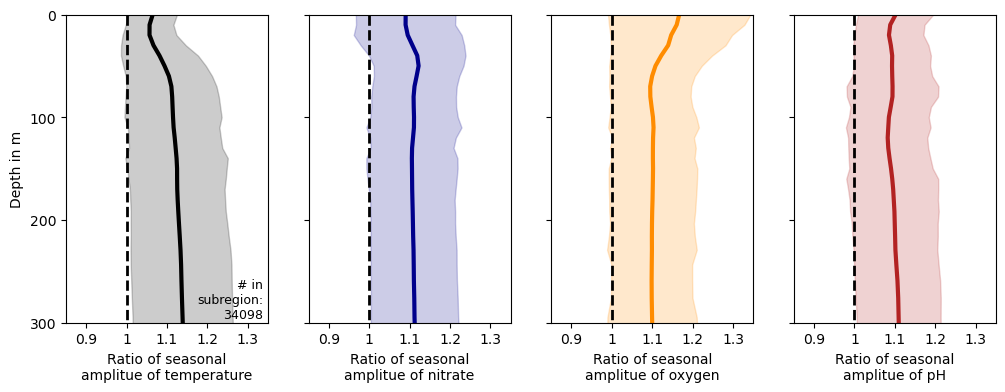

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

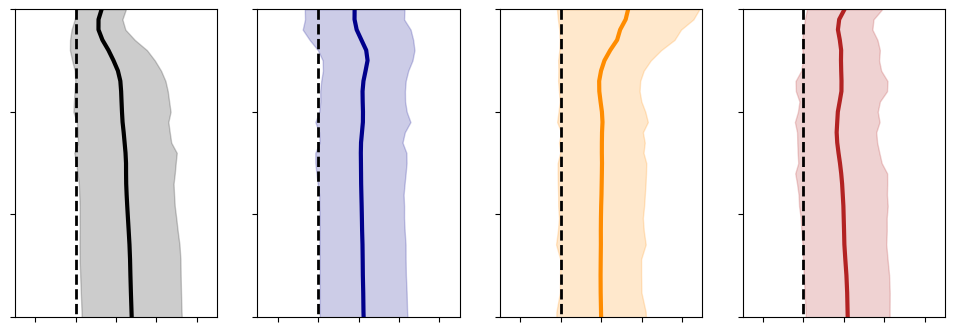

In [17]:
#----
# plot ratio vs depth
#----
print(region_name)

#-------
# one example map (surface, first year)
# one sketch showing what is compared
# 
# polar_60_90N: some weird values at ~500m -> massive std! filter data?

color1 = 'darkblue' # NO3
color2 = 'darkorange' # oxy
color3 = 'firebrick' # pH
color4 = 'black' # temp

color5 = 'black' # vetical line

#color2 = 'black'
lw = 3
fs = 12

save_plots = True
plot_eps = True

#---
# top XX m only
#---

depth_lim = 300
ind_depth = np.where(zlevs0<=depth_lim)[0]
ind_depth = np.concatenate((ind_depth,[ind_depth[-1]+1]))
print(ind_depth)
yticks=[0,100,200,300]#,400,500]

if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    xlim1,xlim2 = 0.85,1.35
    xticks = [0.9,1,1.1,1.2,1.3]
    xticklabels = [0.9,1,1.1,1.2,1.3]
elif (latlim1==-80) | (latlim1==60): # polar
    xlim1,xlim2 = 0.85,1.35 
    xticks = [0.9,1,1.1,1.2,1.3]
    xticklabels = [0.9,1,1.1,1.2,1.3]
else:
    xlim1,xlim2 = 0.85,1.35 
    xticks = [0.9,1,1.1,1.2,1.3]
    xticklabels = [0.9,1,1.1,1.2,1.3]
    #xlim1,xlim2 = 0.7,1.6
    #xticks = [0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6]
    #xticklabels = [0.8,'',1,'',1.2,'',1.4,'',1.6]
    

fig, [ax4,ax1,ax2,ax3] = plt.subplots(1, 4, figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,1]})

ax1.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
ax1.plot(no3_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color1,linewidth=lw,zorder=2)
b1 = no3_ampl_ratio_tropics - no3_ampl_ratio_tropics_std
b2 = no3_ampl_ratio_tropics + no3_ampl_ratio_tropics_std
ax1.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color1, alpha=0.2)
ax1.set_ylim((0,depth_lim))
ax1.invert_yaxis()
ax1.set_xlabel('Ratio of seasonal\namplitue of nitrate')
ax1.set_xlim((xlim1,xlim2))
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels)
ax1.set_yticks(yticks) 
ax1.set_yticklabels([])
#ax1.set_xticks(fontsize=fs)
#ax1.set_yticks(fontsize=fs)

ax2.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
ax2.plot(oxy_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color2,linewidth=lw)
b1 = oxy_ampl_ratio_tropics - oxy_ampl_ratio_tropics_std
b2 = oxy_ampl_ratio_tropics + oxy_ampl_ratio_tropics_std
ax2.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color2, alpha=0.2)
ax2.set_ylim((0,depth_lim))
ax2.invert_yaxis()
ax2.set_xlabel('Ratio of seasonal\namplitue of oxygen')
ax2.set_xlim((xlim1,xlim2))
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
ax2.set_yticks(yticks) 
ax2.set_yticklabels([])
#ax2.set_xticks(fontsize=fs)
#ax2.set_yticks(fontsize=fs)

ax3.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
ax3.plot(pH_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color3,linewidth=lw)
b1 = pH_ampl_ratio_tropics - pH_ampl_ratio_tropics_std
b2 = pH_ampl_ratio_tropics + pH_ampl_ratio_tropics_std
ax3.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color3, alpha=0.2)
ax3.set_ylim((0,depth_lim))
ax3.invert_yaxis()
ax3.set_xlabel('Ratio of seasonal\namplitue of pH')
ax3.set_xlim((xlim1,xlim2))
ax3.set_xticks(xticks)
ax3.set_xticklabels(xticklabels)
ax3.set_yticks(yticks) 
ax3.set_yticklabels([])
#ax3.set_xticks(fontsize=fs)
#ax3.set_yticks(fontsize=fs)

ax4.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
ax4.plot(temp_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color4,linewidth=lw)
b1 = temp_ampl_ratio_tropics - temp_ampl_ratio_tropics_std
b2 = temp_ampl_ratio_tropics + temp_ampl_ratio_tropics_std
ax4.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color4, alpha=0.2)
ax4.set_ylim((0,depth_lim))
ax4.invert_yaxis()
ax4.set_xlabel('Ratio of seasonal\namplitue of temperature')
ax4.set_ylabel('Depth in m')
ax4.set_xlim((xlim1,xlim2))
ax4.set_xticks(xticks)
ax4.set_xticklabels(xticklabels)
ax4.set_yticks(yticks) 
ax4.set_yticklabels(yticks)
#ax4.set_xticks(fontsize=fs)
#ax4.set_yticks(fontsize=fs)
ax4.annotate('# in\nsubregion:\n'+str(np.sum(1*ind_tropics)),xy=(0.975,0.015),\
                    xycoords='axes fraction',fontsize=9,ha='right',color='k') #fontweight='bold',

if save_plots:
    dpicnt = 200
    filename = 'Vertical_profile_ratio_seasonal_amplitude_daily_vs_10day_sampling_'+region_name+'.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()


if plot_eps:
    fig, [ax4,ax1,ax2,ax3] = plt.subplots(1, 4, figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,1]})

    ax1.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
    ax1.plot(no3_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color1,linewidth=lw,zorder=2)
    b1 = no3_ampl_ratio_tropics - no3_ampl_ratio_tropics_std
    b2 = no3_ampl_ratio_tropics + no3_ampl_ratio_tropics_std
    ax1.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color1, alpha=0.2)
    ax1.set_ylim((0,depth_lim))
    ax1.invert_yaxis()
    ax1.set_xlim((xlim1,xlim2))
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([])
    ax1.set_yticks(yticks) 
    ax1.set_yticklabels([])
    #ax1.set_xticks(fontsize=fs)
    #ax1.set_yticks(fontsize=fs)

    ax2.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
    ax2.plot(oxy_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color2,linewidth=lw)
    b1 = oxy_ampl_ratio_tropics - oxy_ampl_ratio_tropics_std
    b2 = oxy_ampl_ratio_tropics + oxy_ampl_ratio_tropics_std
    ax2.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color2, alpha=0.2)
    ax2.set_ylim((0,depth_lim))
    ax2.invert_yaxis()
    ax2.set_xlim((xlim1,xlim2))
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([])
    ax2.set_yticks(yticks) 
    ax2.set_yticklabels([])
    #ax2.set_xticks(fontsize=fs)
    #ax2.set_yticks(fontsize=fs)

    ax3.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
    ax3.plot(pH_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color3,linewidth=lw)
    b1 = pH_ampl_ratio_tropics - pH_ampl_ratio_tropics_std
    b2 = pH_ampl_ratio_tropics + pH_ampl_ratio_tropics_std
    ax3.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color3, alpha=0.2)
    ax3.set_ylim((0,depth_lim))
    ax3.invert_yaxis()
    ax3.set_xlim((xlim1,xlim2))
    ax3.set_xticks(xticks)
    ax3.set_xticklabels([])
    ax3.set_yticks(yticks) 
    ax3.set_yticklabels([])
    #ax3.set_xticks(fontsize=fs)
    #ax3.set_yticks(fontsize=fs)

    ax4.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
    ax4.plot(temp_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color4,linewidth=lw)
    b1 = temp_ampl_ratio_tropics - temp_ampl_ratio_tropics_std
    b2 = temp_ampl_ratio_tropics + temp_ampl_ratio_tropics_std
    ax4.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color4, alpha=0.2)
    ax4.set_ylim((0,depth_lim))
    ax4.invert_yaxis()
    ax4.set_xlim((xlim1,xlim2))
    ax4.set_xticks(xticks)
    ax4.set_xticklabels([])
    ax4.set_yticks(yticks) 
    ax4.set_yticklabels([])
    #ax4.set_xticks(fontsize=fs)
    #ax4.set_yticks(fontsize=fs)

    if save_plots:
        dpicnt = 200
        filename = 'Vertical_profile_ratio_seasonal_amplitude_daily_vs_10day_sampling_'+region_name+'.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)

    plt.show()

#---
# why is there no data below ~1800m????? 
# -> it had to do with floats that didn't experience any seasonal variability below that depth 
# -> these ended up as "inf" in the data set, causing NaNs in the regional avg
# -> it has been corrected in the calculation of the ratio
# (but I plan to only show the upper 1000m at max in the revised version of the case study, i.e., it does not matter!)
#---

# daily vs 10-daily


tropics_21S_21N


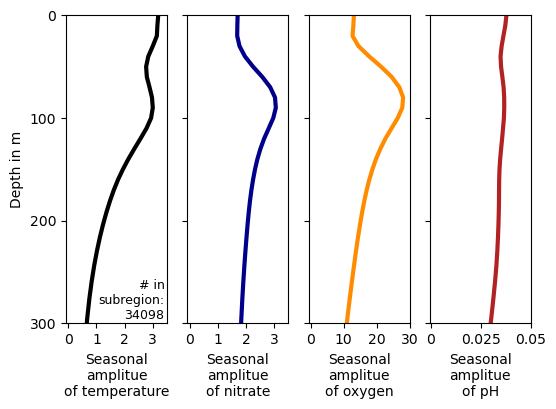

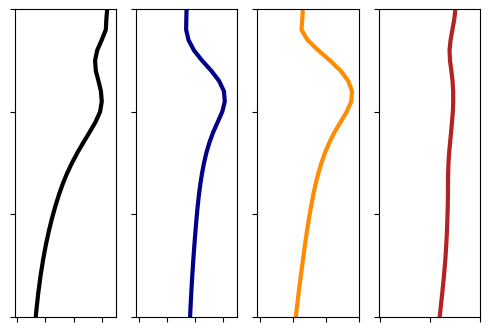

In [18]:
#---
# plot seasonal amplitude for 10-day sampling
#---
print(region_name)

#latlim1 = 60 # southern limit
#latlim2 = 90  # northern limit

#latlim1 = 21 # southern limit
#latlim2 = 60  # northern limit

#latlim1 = -21 # southern limit
#latlim2 = 21  # northern limit

#latlim1 = -60 # southern limit
#latlim2 = -21  # northern limit

#latlim1 = -90 # southern limit
#latlim2 = -60  # northern limit

fig, [ax4,ax1,ax2,ax3] = plt.subplots(1, 4, figsize=(6,4),gridspec_kw={'width_ratios': [1,1,1,1]})

#ax1.vlines(0,0,depth_lim,color=color2,linewidth=1)
ax1.plot(no3_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color1,linewidth=lw,zorder=2)
ax1.set_ylim((0,depth_lim))
ax1.invert_yaxis()
ax1.set_xlabel('Seasonal\namplitue\nof nitrate')
if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    ax1.set_xlim((-0.1,4))
    ax1.set_xticks([0,1,2,3,4]) 
    ax1.set_xticklabels([0,'',2,'',4])
elif (latlim1==-80) | (latlim1==60): # polar
    ax1.set_xlim((-0.1,6.5))
    ax1.set_xticks([0,2,4,6]) 
    ax1.set_xticklabels([0,2,4,6])
else:
    ax1.set_xlim((-0.1,3.5))
    ax1.set_xticks([0,1,2,3]) 
    ax1.set_xticklabels([0,1,2,3])
ax1.set_yticks(yticks) 
ax1.set_yticklabels([])
#ax1.set_xticks(fontsize=fs)
#ax1.set_yticks(fontsize=fs)

#ax2.vlines(0,0,depth_lim,color=color2,linewidth=1)
ax2.plot(oxy_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color2,linewidth=lw)
ax2.set_ylim((0,depth_lim))
ax2.invert_yaxis()
ax2.set_xlabel('Seasonal\namplitue\nof oxygen')
if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    ax2.set_xlim((-0.7,40))
    ax2.set_xticks([0,10,20,30,40]) 
    ax2.set_xticklabels([0,'',20,'',40])
elif (latlim1==-80) | (latlim1==60): # polar
    ax2.set_xlim((-0.7,65))
    ax2.set_xticks([0,20,40,60]) 
    ax2.set_xticklabels([0,20,40,60])
else:
    ax2.set_xlim((-0.7,30))
    ax2.set_xticks([0,10,20,30]) 
    ax2.set_xticklabels([0,10,20,30])
ax2.set_yticks(yticks) 
ax2.set_yticklabels([])
#ax2.set_yticks(fontsize=fs)

#ax3.vlines(0,0,depth_lim,color=color2,linewidth=1)
ax3.plot(pH_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color3,linewidth=lw)
ax3.set_ylim((0,depth_lim))
ax3.invert_yaxis()
ax3.set_xlabel('Seasonal\namplitue\nof pH')
if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    ax3.set_xlim((-0.0004,0.1))
    ax3.set_xticks([0,0.025,0.05,0.075,0.1]) 
    ax3.set_xticklabels([0,'',0.05,'',0.1])
elif (latlim1==-80) | (latlim1==60): # polar
    ax3.set_xlim((-0.0004,0.1))
    ax3.set_xticks([0,0.05,0.1]) 
    ax3.set_xticklabels([0,0.05,0.1])
else:
    ax3.set_xlim((-0.0004,0.05))
    ax3.set_xticks([0,0.025,0.05]) 
    ax3.set_xticklabels([0,0.025,0.05])
ax3.set_yticks(yticks) 
ax3.set_yticklabels([])
#ax3.set_xticks(fontsize=fs)
#ax3.set_yticks(fontsize=fs)

#ax4.vlines(0,0,depth_lim,color=color2,linewidth=1)
ax4.plot(temp_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color4,linewidth=lw)
ax4.set_ylim((0,depth_lim))
ax4.invert_yaxis()
ax4.set_xlabel('Seasonal\namplitue\nof temperature')
ax4.set_ylabel('Depth in m')
if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    ax4.set_xlim((-0.08,8.2))
    ax4.set_xticks([0,2,4,6,8]) 
    ax4.set_xticklabels([0,'',4,'',8])
elif (latlim1==-80) | (latlim1==60): # polar
    ax4.set_xlim((-0.08,3.5))
    ax4.set_xticks([0,1,2,3]) 
    ax4.set_xticklabels([0,1,2,3])
else:
    ax4.set_xlim((-0.08,3.5))
    ax4.set_xticks([0,1,2,3]) 
    ax4.set_xticklabels([0,1,2,3])
ax4.set_yticks(yticks) 
ax4.set_yticklabels(yticks)
ax4.annotate('# in\nsubregion:\n'+str(np.sum(1*ind_tropics)),xy=(0.975,0.015),\
                    xycoords='axes fraction',fontsize=9,ha='right',color='k') #fontweight='bold',


if save_plots:
    dpicnt = 200
    filename = 'Vertical_profile_seasonal_amplitude_daily_vs_10day_sampling_'+region_name+'.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
plt.show()

if plot_eps:
    
    fig, [ax4,ax1,ax2,ax3] = plt.subplots(1, 4, figsize=(6,4),gridspec_kw={'width_ratios': [1,1,1,1]})
    
    ax1.plot(no3_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color1,linewidth=lw,zorder=2)
    ax1.set_ylim((0,depth_lim))
    ax1.invert_yaxis()
    if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
        ax1.set_xlim((-0.1,4))
        ax1.set_xticks([0,1,2,3,4]) 
        ax1.set_xticklabels([])
    elif (latlim1==-80) | (latlim1==60): # polar
        ax1.set_xlim((-0.1,6.5))
        ax1.set_xticks([0,2,4,6]) 
        ax1.set_xticklabels([])
    else:
        ax1.set_xlim((-0.1,3.5))
        ax1.set_xticks([0,1,2,3]) 
        ax1.set_xticklabels([])
    ax1.set_yticks(yticks) 
    ax1.set_yticklabels([])
    
    ax2.plot(oxy_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color2,linewidth=lw)
    ax2.set_ylim((0,depth_lim))
    ax2.invert_yaxis()
    if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
        ax2.set_xlim((-0.7,40))
        ax2.set_xticks([0,10,20,30,40]) 
        ax2.set_xticklabels([])
    elif (latlim1==-80) | (latlim1==60): # polar
        ax2.set_xlim((-0.7,65))
        ax2.set_xticks([0,20,40,60]) 
        ax2.set_xticklabels([])
    else:
        ax2.set_xlim((-0.7,30))
        ax2.set_xticks([0,10,20,30]) 
        ax2.set_xticklabels([])
    ax2.set_yticks(yticks) 
    ax2.set_yticklabels([])
    #ax2.set_yticks(fontsize=fs)

    ax3.plot(pH_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color3,linewidth=lw)
    ax3.set_ylim((0,depth_lim))
    ax3.invert_yaxis()
    if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
        ax3.set_xlim((-0.0004,0.1))
        ax3.set_xticks([0,0.025,0.05,0.075,0.1]) 
        ax3.set_xticklabels([])
    elif (latlim1==-80) | (latlim1==60): # polar
        ax3.set_xlim((-0.0004,0.1))
        ax3.set_xticks([0,0.05,0.1]) 
        ax3.set_xticklabels([])
    else:
        ax3.set_xlim((-0.0004,0.05))
        ax3.set_xticks([0,0.025,0.05]) 
        ax3.set_xticklabels([])
    ax3.set_yticks(yticks) 
    ax3.set_yticklabels([])

    ax4.plot(temp_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color4,linewidth=lw)
    ax4.set_ylim((0,depth_lim))
    ax4.invert_yaxis()
    if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
        ax4.set_xlim((-0.08,8.2))
        ax4.set_xticks([0,2,4,6,8]) 
        ax4.set_xticklabels([])
    elif (latlim1==-80) | (latlim1==60): # polar
        ax4.set_xlim((-0.08,3.5))
        ax4.set_xticks([0,1,2,3]) 
        ax4.set_xticklabels([])
    else:
        ax4.set_xlim((-0.08,3.5))
        ax4.set_xticks([0,1,2,3]) 
        ax4.set_xticklabels([])
    ax4.set_yticks(yticks) 
    ax4.set_yticklabels([])

    if save_plots:
        dpicnt = 200
        filename = 'Vertical_profile_seasonal_amplitude_daily_vs_10day_sampling_'+region_name+'.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    plt.show()


tropics_21S_21N
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


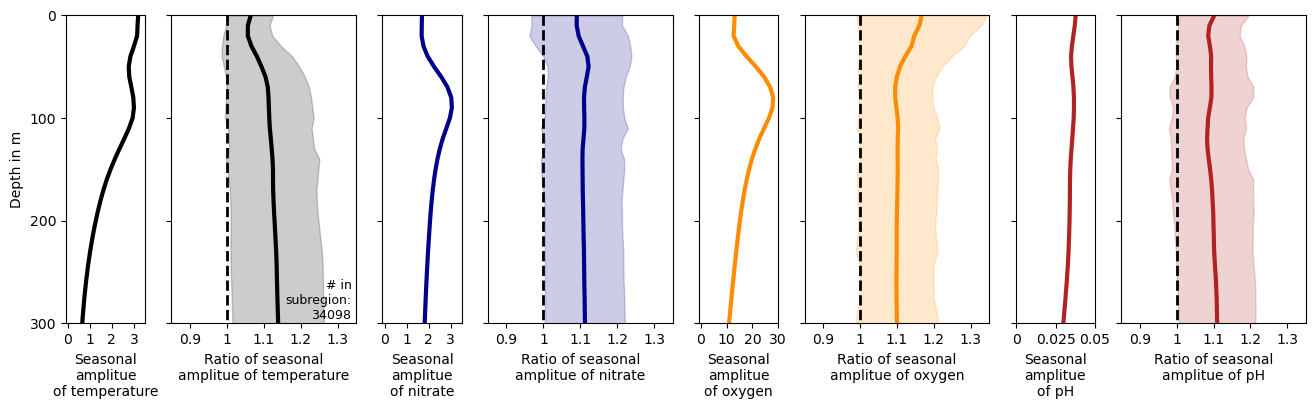

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

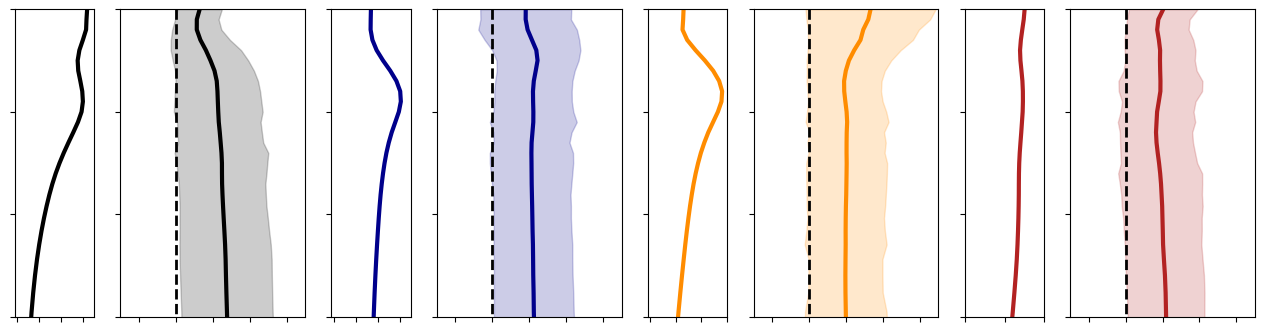

In [19]:
#----
# plot ratio vs depth
#----
print(region_name)

#-------
# one example map (surface, first year)
# one sketch showing what is compared
# 
# polar_60_90N: some weird values at ~500m -> massive std! filter data?

color1 = 'darkblue' # NO3
color2 = 'darkorange' # oxy
color3 = 'firebrick' # pH
color4 = 'black' # temp

color5 = 'black' # vetical line

#color2 = 'black'
lw = 3
fs = 12

save_plots = True
plot_eps = True

#---
# top XX m only
#---

depth_lim = 300
ind_depth = np.where(zlevs0<=depth_lim)[0]
ind_depth = np.concatenate((ind_depth,[ind_depth[-1]+1]))
print(ind_depth)
yticks=[0,100,200,300]#,400,500]

if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    xlim1,xlim2 = 0.85,1.35
    xticks = [0.9,1,1.1,1.2,1.3]
    xticklabels = [0.9,1,1.1,1.2,1.3]
elif (latlim1==-80) | (latlim1==60): # polar
    xlim1,xlim2 = 0.85,1.35 
    xticks = [0.9,1,1.1,1.2,1.3]
    xticklabels = [0.9,1,1.1,1.2,1.3]
else:
    xlim1,xlim2 = 0.85,1.35 
    xticks = [0.9,1,1.1,1.2,1.3]
    xticklabels = [0.9,1,1.1,1.2,1.3]
    #xlim1,xlim2 = 0.7,1.6
    #xticks = [0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6]
    #xticklabels = [0.8,'',1,'',1.2,'',1.4,'',1.6]

w1,w2 = 0.3,0.7
fig, [ax0a,ax4,ax0b,ax1,ax0c,ax2,ax0d,ax3] = plt.subplots(1, 8, figsize=(16,4),gridspec_kw={'width_ratios': [w1,w2,w1,w2,w1,w2,w1,w2]})
#----
# absolute amplitude
#----
ax0b.plot(no3_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color1,linewidth=lw,zorder=2)
ax0b.set_ylim((0,depth_lim))
ax0b.invert_yaxis()
ax0b.set_xlabel('Seasonal\namplitue\nof nitrate')
if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    ax0b.set_xlim((-0.1,4))
    ax0b.set_xticks([0,1,2,3,4]) 
    ax0b.set_xticklabels([0,'',2,'',4])
elif (latlim1==-80) | (latlim1==60): # polar
    ax0b.set_xlim((-0.1,6.5))
    ax0b.set_xticks([0,2,4,6]) 
    ax0b.set_xticklabels([0,2,4,6])
else:
    ax0b.set_xlim((-0.1,3.5))
    ax0b.set_xticks([0,1,2,3]) 
    ax0b.set_xticklabels([0,1,2,3])
ax0b.set_yticks(yticks) 
ax0b.set_yticklabels([])

ax0c.plot(oxy_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color2,linewidth=lw)
ax0c.set_ylim((0,depth_lim))
ax0c.invert_yaxis()
ax0c.set_xlabel('Seasonal\namplitue\nof oxygen')
if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    ax0c.set_xlim((-0.7,40))
    ax0c.set_xticks([0,10,20,30,40]) 
    ax0c.set_xticklabels([0,'',20,'',40])
elif (latlim1==-80) | (latlim1==60): # polar
    ax0c.set_xlim((-0.7,65))
    ax0c.set_xticks([0,20,40,60]) 
    ax0c.set_xticklabels([0,20,40,60])
else:
    ax0c.set_xlim((-0.7,30))
    ax0c.set_xticks([0,10,20,30]) 
    ax0c.set_xticklabels([0,10,20,30])
ax0c.set_yticks(yticks) 
ax0c.set_yticklabels([])

ax0d.plot(pH_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color3,linewidth=lw)
ax0d.set_ylim((0,depth_lim))
ax0d.invert_yaxis()
ax0d.set_xlabel('Seasonal\namplitue\nof pH')
if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    ax0d.set_xlim((-0.0004,0.1))
    ax0d.set_xticks([0,0.025,0.05,0.075,0.1]) 
    ax0d.set_xticklabels([0,'',0.05,'',0.1])
elif (latlim1==-80) | (latlim1==60): # polar
    ax0d.set_xlim((-0.0004,0.1))
    ax0d.set_xticks([0,0.05,0.1]) 
    ax0d.set_xticklabels([0,0.05,0.1])
else:
    ax0d.set_xlim((-0.0004,0.05))
    ax0d.set_xticks([0,0.025,0.05]) 
    ax0d.set_xticklabels([0,0.025,0.05])
ax0d.set_yticks(yticks) 
ax0d.set_yticklabels([])

ax0a.plot(temp_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color4,linewidth=lw)
ax0a.set_ylim((0,depth_lim))
ax0a.invert_yaxis()
ax0a.set_xlabel('Seasonal\namplitue\nof temperature')
ax0a.set_ylabel('Depth in m')
if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
    ax0a.set_xlim((-0.08,8.2))
    ax0a.set_xticks([0,2,4,6,8]) 
    ax0a.set_xticklabels([0,'',4,'',8])
elif (latlim1==-80) | (latlim1==60): # polar
    ax0a.set_xlim((-0.08,3.5))
    ax0a.set_xticks([0,1,2,3]) 
    ax0a.set_xticklabels([0,1,2,3])
else:
    ax0a.set_xlim((-0.08,3.5))
    ax0a.set_xticks([0,1,2,3]) 
    ax0a.set_xticklabels([0,1,2,3])
ax0a.set_yticks(yticks) 
ax0a.set_yticklabels(yticks)

#----
# ratio of amplitudes
#----
ax1.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
ax1.plot(no3_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color1,linewidth=lw,zorder=2)
b1 = no3_ampl_ratio_tropics - no3_ampl_ratio_tropics_std
b2 = no3_ampl_ratio_tropics + no3_ampl_ratio_tropics_std
ax1.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color1, alpha=0.2)
ax1.set_ylim((0,depth_lim))
ax1.invert_yaxis()
ax1.set_xlabel('Ratio of seasonal\namplitue of nitrate')
ax1.set_xlim((xlim1,xlim2))
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels)
ax1.set_yticks(yticks) 
ax1.set_yticklabels([])
#ax1.set_xticks(fontsize=fs)
#ax1.set_yticks(fontsize=fs)

ax2.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
ax2.plot(oxy_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color2,linewidth=lw)
b1 = oxy_ampl_ratio_tropics - oxy_ampl_ratio_tropics_std
b2 = oxy_ampl_ratio_tropics + oxy_ampl_ratio_tropics_std
ax2.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color2, alpha=0.2)
ax2.set_ylim((0,depth_lim))
ax2.invert_yaxis()
ax2.set_xlabel('Ratio of seasonal\namplitue of oxygen')
ax2.set_xlim((xlim1,xlim2))
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
ax2.set_yticks(yticks) 
ax2.set_yticklabels([])
#ax2.set_xticks(fontsize=fs)
#ax2.set_yticks(fontsize=fs)

ax3.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
ax3.plot(pH_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color3,linewidth=lw)
b1 = pH_ampl_ratio_tropics - pH_ampl_ratio_tropics_std
b2 = pH_ampl_ratio_tropics + pH_ampl_ratio_tropics_std
ax3.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color3, alpha=0.2)
ax3.set_ylim((0,depth_lim))
ax3.invert_yaxis()
ax3.set_xlabel('Ratio of seasonal\namplitue of pH')
ax3.set_xlim((xlim1,xlim2))
ax3.set_xticks(xticks)
ax3.set_xticklabels(xticklabels)
ax3.set_yticks(yticks) 
ax3.set_yticklabels([])
#ax3.set_xticks(fontsize=fs)
#ax3.set_yticks(fontsize=fs)

ax4.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
ax4.plot(temp_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color4,linewidth=lw)
b1 = temp_ampl_ratio_tropics - temp_ampl_ratio_tropics_std
b2 = temp_ampl_ratio_tropics + temp_ampl_ratio_tropics_std
ax4.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color4, alpha=0.2)
ax4.set_ylim((0,depth_lim))
ax4.invert_yaxis()
ax4.set_xlabel('Ratio of seasonal\namplitue of temperature')
ax4.set_xlim((xlim1,xlim2))
ax4.set_xticks(xticks)
ax4.set_xticklabels(xticklabels)
ax4.set_yticks(yticks) 
ax4.set_yticklabels([])
#ax4.set_xticks(fontsize=fs)
#ax4.set_yticks(fontsize=fs)
ax4.annotate('# in\nsubregion:\n'+str(np.sum(1*ind_tropics)),xy=(0.975,0.015),\
                    xycoords='axes fraction',fontsize=9,ha='right',color='k') #fontweight='bold',

if save_plots:
    dpicnt = 200
    filename = 'Vertical_profile_COMBINED_absolute_and_ratio_seasonal_amplitude_daily_vs_10day_sampling_'+region_name+'.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()


if plot_eps:
    fig, [ax0a,ax4,ax0b,ax1,ax0c,ax2,ax0d,ax3] = plt.subplots(1, 8, figsize=(16,4),gridspec_kw={'width_ratios': [w1,w2,w1,w2,w1,w2,w1,w2]})
    #----
    # absolute amplitude
    #----
    ax0b.plot(no3_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color1,linewidth=lw,zorder=2)
    ax0b.set_ylim((0,depth_lim))
    ax0b.invert_yaxis()
    if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
        ax0b.set_xlim((-0.1,4))
        ax0b.set_xticks([0,1,2,3,4]) 
        ax0b.set_xticklabels([])
    elif (latlim1==-80) | (latlim1==60): # polar
        ax0b.set_xlim((-0.1,6.5))
        ax0b.set_xticks([0,2,4,6]) 
        ax0b.set_xticklabels([])
    else:
        ax0b.set_xlim((-0.1,3.5))
        ax0b.set_xticks([0,1,2,3]) 
        ax0b.set_xticklabels([])
    ax0b.set_yticks(yticks) 
    ax0b.set_yticklabels([])

    ax0c.plot(oxy_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color2,linewidth=lw)
    ax0c.set_ylim((0,depth_lim))
    ax0c.invert_yaxis()
    if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
        ax0c.set_xlim((-0.7,40))
        ax0c.set_xticks([0,10,20,30,40]) 
        ax0c.set_xticklabels([])
    elif (latlim1==-80) | (latlim1==60): # polar
        ax0c.set_xlim((-0.7,65))
        ax0c.set_xticks([0,20,40,60]) 
        ax0c.set_xticklabels([])
    else:
        ax0c.set_xlim((-0.7,30))
        ax0c.set_xticks([0,10,20,30]) 
        ax0c.set_xticklabels([])
    ax0c.set_yticks(yticks) 
    ax0c.set_yticklabels([])

    ax0d.plot(pH_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color3,linewidth=lw)
    ax0d.set_ylim((0,depth_lim))
    ax0d.invert_yaxis()
    if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
        ax0d.set_xlim((-0.0004,0.1))
        ax0d.set_xticks([0,0.025,0.05,0.075,0.1]) 
        ax0d.set_xticklabels([])
    elif (latlim1==-80) | (latlim1==60): # polar
        ax0d.set_xlim((-0.0004,0.1))
        ax0d.set_xticks([0,0.05,0.1]) 
        ax0d.set_xticklabels([])
    else:
        ax0d.set_xlim((-0.0004,0.05))
        ax0d.set_xticks([0,0.025,0.05]) 
        ax0d.set_xticklabels([])
    ax0d.set_yticks(yticks) 
    ax0d.set_yticklabels([])

    ax0a.plot(temp_range_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color4,linewidth=lw)
    ax0a.set_ylim((0,depth_lim))
    ax0a.invert_yaxis()
    if (latlim1==-60) | (latlim1==21): # subtropical & subpolar
        ax0a.set_xlim((-0.08,8.2))
        ax0a.set_xticks([0,2,4,6,8]) 
        ax0a.set_xticklabels([])
    elif (latlim1==-80) | (latlim1==60): # polar
        ax0a.set_xlim((-0.08,3.5))
        ax0a.set_xticks([0,1,2,3]) 
        ax0a.set_xticklabels([])
    else:
        ax0a.set_xlim((-0.08,3.5))
        ax0a.set_xticks([0,1,2,3]) 
        ax0a.set_xticklabels([])
    ax0a.set_yticks(yticks) 
    ax0a.set_yticklabels([])

    ax1.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
    ax1.plot(no3_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color1,linewidth=lw,zorder=2)
    b1 = no3_ampl_ratio_tropics - no3_ampl_ratio_tropics_std
    b2 = no3_ampl_ratio_tropics + no3_ampl_ratio_tropics_std
    ax1.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color1, alpha=0.2)
    ax1.set_ylim((0,depth_lim))
    ax1.invert_yaxis()
    ax1.set_xlim((xlim1,xlim2))
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([])
    ax1.set_yticks(yticks) 
    ax1.set_yticklabels([])
    #ax1.set_xticks(fontsize=fs)
    #ax1.set_yticks(fontsize=fs)

    ax2.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
    ax2.plot(oxy_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color2,linewidth=lw)
    b1 = oxy_ampl_ratio_tropics - oxy_ampl_ratio_tropics_std
    b2 = oxy_ampl_ratio_tropics + oxy_ampl_ratio_tropics_std
    ax2.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color2, alpha=0.2)
    ax2.set_ylim((0,depth_lim))
    ax2.invert_yaxis()
    ax2.set_xlim((xlim1,xlim2))
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([])
    ax2.set_yticks(yticks) 
    ax2.set_yticklabels([])
    #ax2.set_xticks(fontsize=fs)
    #ax2.set_yticks(fontsize=fs)

    ax3.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
    ax3.plot(pH_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color3,linewidth=lw)
    b1 = pH_ampl_ratio_tropics - pH_ampl_ratio_tropics_std
    b2 = pH_ampl_ratio_tropics + pH_ampl_ratio_tropics_std
    ax3.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color3, alpha=0.2)
    ax3.set_ylim((0,depth_lim))
    ax3.invert_yaxis()
    ax3.set_xlim((xlim1,xlim2))
    ax3.set_xticks(xticks)
    ax3.set_xticklabels([])
    ax3.set_yticks(yticks) 
    ax3.set_yticklabels([])
    #ax3.set_xticks(fontsize=fs)
    #ax3.set_yticks(fontsize=fs)

    ax4.vlines(1,0,depth_lim,color=color5,linewidth=2,linestyle='--')
    ax4.plot(temp_ampl_ratio_tropics[ind_depth],zlevs0[:-1][ind_depth],color=color4,linewidth=lw)
    b1 = temp_ampl_ratio_tropics - temp_ampl_ratio_tropics_std
    b2 = temp_ampl_ratio_tropics + temp_ampl_ratio_tropics_std
    ax4.fill_betweenx(zlevs0[:-1][ind_depth],b1[ind_depth], b2[ind_depth], color=color4, alpha=0.2)
    ax4.set_ylim((0,depth_lim))
    ax4.invert_yaxis()
    ax4.set_xlim((xlim1,xlim2))
    ax4.set_xticks(xticks)
    ax4.set_xticklabels([])
    ax4.set_yticks(yticks) 
    ax4.set_yticklabels([])
    #ax4.set_xticks(fontsize=fs)
    #ax4.set_yticks(fontsize=fs)

    if save_plots:
        dpicnt = 200
        filename = 'Vertical_profile_COMBINED_absolute_and_ratio_seasonal_amplitude_daily_vs_10day_sampling_'+region_name+'.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)

    plt.show()

#---
# why is there no data below ~1800m????? 
# -> it had to do with floats that didn't experience any seasonal variability below that depth 
# -> these ended up as "inf" in the data set, causing NaNs in the regional avg
# -> it has been corrected in the calculation of the ratio
# (but I plan to only show the upper 1000m at max in the revised version of the case study, i.e., it does not matter!)
#---

# daily vs 10-daily


In [ ]:
print(savepath)


In [21]:
#---
# plot a map and color the points as a function of the ratio: are there regional differences?
#---
# plot starting position of each float FOR ONE YEAR ONLY
# NOTE: the distribution of floats changes over the years!!! 

# get first non-NaN entry (depending on the randomly chosen start index, some floats might have a NaN on the first entry here...)
lat0=np.zeros(lat10.shape[1])
lon0=np.zeros(lon10.shape[1])
for ff in tqdm(range(0,lat10.shape[1])):
    aux1 = lat10[:,ff]
    aux2 = lon10[:,ff]
    if ~np.isnan(aux1[0]):
        lat0[ff] = aux1[0]
        lon0[ff] = aux2[0]
    else:
        lat0[ff] = aux1[1]
        lon0[ff] = aux2[1]
    del aux1,aux2
    

100%|██████████| 53041/53041 [00:15<00:00, 3462.76it/s]


Minimum for chosen depth level: <xarray.DataArray 'ratio_no3' ()>
array(1.)
Coordinates:
    depth    float32 10.0


100%|██████████| 8647/8647 [00:11<00:00, 771.82it/s]


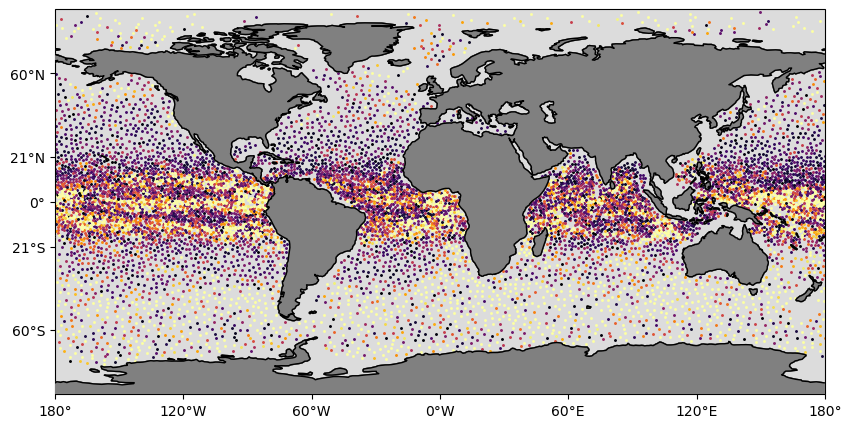

In [36]:
#---
# plot a map and color the points as a function of the ratio: are there regional differences?
#---
# plot starting position of each float FOR ONE YEAR ONLY
# NOTE: the distribution of floats changes over the years!!!   

num_floats_per_year = np.asarray([int(x) for x in num_floats_per_year])
num_floats_per_year_cumsum = np.cumsum(np.asarray([int(x) for x in np.concatenate(([0],num_floats_per_year))]))

dd = 0 # choose depth level to plot
yy = 0 # choose year to plot (only starting positions of all floats at the beginning of this year will be plotted)

save_plots = True
plot_eps = True # colorbar

#cmap1 = plt.cm.inferno #magma #RdYlBu_r
#cmap1 = plt.cm.RdYlBu_r
#color_string = 'RdYlBu_r' #'_inferno'
cmap1 = plt.cm.inferno
color_string = '_inferno'

ms = 1.2
vmin1,vmax1 = 1,1.15
cticks = [1,1.025,1.05,1.075,1.1,1.125,1.15]
cticklabels = ['0','2.5','5','7.5','10','12.5','15']
cticklabels_eps = ['','','','','','','']

print('Minimum for chosen depth level:',np.min(ratio_no3[dd,:]))

fig = plt.figure(figsize=(18,5)) # x, y
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
#ax.stock_img()
ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
ax.coastlines(zorder=51)
ax.coastlines()
ax.set_extent([-179, 179, -90, 90])
ax.set_facecolor('gainsboro')#whitesmoke')

for nn in tqdm(range(num_floats_per_year_cumsum[yy],num_floats_per_year_cumsum[yy+1])): # I don't want to plot starting locations of floats for all 5 years!
    #print(no3_ampl_ratio[dd,nn])
    plt.scatter(lon0[nn], lat0[nn],c=ratio_pH[dd,nn],s=ms,vmin=vmin1,vmax=vmax1,cmap=cmap1,marker='o',transform=ccrs.PlateCarree())
    #plt.plot(lon0[nn], lat0[nn],color='darkblue', marker='o',markersize=ms,transform=ccrs.Geodetic())
    
#plt.colorbar(orientation='vertical')

ax.yaxis.tick_left()
ax.set_xticks([-180,-120, -60, 0, 60, 120, 180],crs=ccrs.PlateCarree())
ax.set_yticks([-60, -21, 0, 21, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
    
if save_plots:
    dpicnt = 200
    filename = 'Map_pH_seasonal_amplitude_daily_vs_10day_sampling_year_'+year_list[0]+'_90S_90N'+color_string+'.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()


Separate COLORBAR...


100%|██████████| 1/1 [00:00<00:00, 562.09it/s]

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/vertical_profiles_biomes/6year_run/Map_pH_seasonal_amplitude_daily_vs_10day_sampling_year_0055_COLORBAR_inferno.png


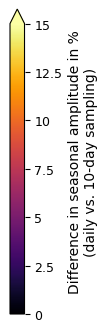

100%|██████████| 1/1 [00:00<00:00, 627.80it/s]


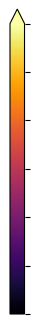

In [37]:
#-----
# COLORBAR: plot separately
#-----
print('Separate COLORBAR...')

#cmap1 = plt.cm.inferno
#color_string = '_inferno' 

#cmap1 = plt.cm.RdYlBu_r
#color_string = 'RdYlBu_r' #'_inferno'

fig = plt.figure(figsize=(7,18))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-150))
ax.set_extent([-180, 180, -90, 90])
for nn in tqdm(range(num_floats_per_year_cumsum[yy],num_floats_per_year_cumsum[yy]+1)):#num_floats_per_year_cumsum[yy+1])): # I don't want to plot starting locations of floats for all 5 years!
    plt.scatter(lon0[nn], lat0[nn],c=ratio_no3[dd,nn],s=ms,vmin=vmin1,vmax=vmax1,cmap=cmap1,marker='o',transform=ccrs.PlateCarree())               
#mm1=ax.contourf(lon_reg, lat_reg, vel_reg_e3sm_2 - vel_reg_scripps,\
#                   levels=levels1,extend='both',cmap=cm.RdBu_r,transform=ccrs.PlateCarree())
cbar = plt.colorbar(orientation='vertical',fraction=0.075, pad=0.02,shrink=0.22,ticks=cticks,extend='max')
cbar.ax.set_yticklabels(cticklabels)
cbar.set_label('Difference in seasonal amplitude in %\n(daily vs. 10-day sampling)',fontsize=fs-2)
cbar.ax.tick_params(labelsize=fs-3)
fig.gca().set_visible(False)
if save_plots:
    filename = 'Map_pH_seasonal_amplitude_daily_vs_10day_sampling_year_'+year_list[0]+'_COLORBAR'+color_string+'.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
plt.show()

#---
# eps
#---
if plot_eps:
    fig = plt.figure(figsize=(7,18))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-150))
    ax.set_extent([-180, 180, -90, 90])
    for nn in tqdm(range(num_floats_per_year_cumsum[yy],num_floats_per_year_cumsum[yy]+1)):#num_floats_per_year_cumsum[yy+1])): # I don't want to plot starting locations of floats for all 5 years!
        plt.scatter(lon0[nn], lat0[nn],c=ratio_no3[dd,nn],s=ms,vmin=vmin1,vmax=vmax1,cmap=cmap1,marker='o',transform=ccrs.PlateCarree())               
    cbar = plt.colorbar(orientation='vertical',fraction=0.075, pad=0.02,shrink=0.22,ticks=cticks,extend='max')
    cbar.ax.set_yticklabels(cticklabels_eps)
    cbar.ax.tick_params(labelsize=fs-3)
    fig.gca().set_visible(False)
    if save_plots:
        filename = 'Map_pH_seasonal_amplitude_daily_vs_10day_sampling_year_'+year_list[0]+'_COLORBAR'+color_string+'.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight')
        del filename

    plt.show()

In [ ]:
print(savepath)

In [ ]:
#---
# Southern Ocean: compare difference in seasonal amplitude to velocity -> no clear pattern visible
#---

In [38]:
####
# load mesh info, velocity etc
####

rad_to_deg = 180.0/np.pi
latlim = -45.0

path_mesh = '/global/cfs/cdirs/m4003/maltrud/'
meshID = 'EC30to60E2r2'
meshfile = xr. open_dataset(path_mesh+'ocean.'+meshID+'.210210.nc')
#print(meshfile)

lon_model  = meshfile['lonCell'].values*rad_to_deg
lat_model  = meshfile['latCell'].values*rad_to_deg
topo = meshfile['bottomDepth'].values
area = meshfile['areaCell'].values
zlevs            = meshfile['refBottomDepth'].values
layerThickness   = meshfile['layerThickness'].values
restingThickness = meshfile['restingThickness'].values

print(len(lon_model),'nodes in mesh')
print(topo.shape)
print(area.shape)
print('Min/Max lon:',np.min(lon_model),np.max(lon_model))
print('Min/Max lat:',np.min(lat_model),np.max(lat_model))
print('layerThickness.shape:',layerThickness.shape)
print('restingThickness.shape:',restingThickness.shape)

meshfile.close()

inputroot = '/global/cfs/cdirs/m4003/maltrud/6year/monthlyEulerianAverages/'
year_list = ['0055']#,'0056','0057','0058','0059','0060']

#---
# plot map of velocities at 1000m: step2
#---

# Load data from input file (model output)
varname1 = 'timeMonthly_avg_velocityMeridional'
varname2 = 'timeMonthly_avg_velocityZonal'
print(zlevs[38])

velocity = np.zeros(area.shape[0])
for yy in range(0,len(year_list)):
    print('Load year '+year_list[yy])
    inputfile_run1 = inputroot+'monthlyAverageEulerianFields.year'+year_list[yy]+'.nc'
    finput_run1 = xr.open_dataset(inputfile_run1)

    # MPAS-O mesh for EC30to60E2r2 run 1
    vel_1 = finput_run1[varname1].data 
    vel_1 = np.squeeze(vel_1)[:,:,38].mean(axis=0) # annual mean, index 38 = 928m
    #vel_1
    vel_2 = finput_run1[varname2].data
    vel_2 = np.squeeze(vel_2)[:,:,38].mean(axis=0) # annual mean, index 38 = 928m
    #print(vel_1.shape,vel_2.shape)

    velocity = velocity+np.sqrt(np.multiply(vel_1,vel_1) + np.multiply(vel_2,vel_2))
    print(velocity.shape,np.min(velocity),np.max(velocity))

# get avg velocity field
print('6-year average:')
velocity = np.divide(velocity,len(year_list))
print(velocity.shape,np.min(velocity),np.max(velocity))



236853 nodes in mesh
(236853,)
(236853,)
Min/Max lon: 0.0007300572350528742 359.997672445938
Min/Max lat: -78.53259417674468 89.94461290099375
layerThickness.shape: (1, 236853, 60)
restingThickness.shape: (236853, 60)
928.0434765624996
Load year 0055
(236853,) 0.0 0.26856759190559387
6-year average:
(236853,) 0.0 0.26856759190559387


In [49]:
print(closest_node.shape)
print(lat10.shape)


(37, 53041)
(37, 53041)


In [66]:
#---
# plot
#---

#print(lat10.shape)
#print(ratio_pH.shape)
aux1 = ratio_pH[0,0:int(num_floats_per_year[0])] # year 2012 only
aux2 = closest_node[0,0:int(num_floats_per_year[0])]
print(aux1.shape)
print(aux2.shape)

latlim1 = -45

indSO = np.where(lat_model<=latlim1)[0]
velocitySO = velocity[indSO]
print(velocitySO.shape)

print(np.min(indSO))

# for each model grid cell in the SO, find floats that were colocated to that cell (year 2012 only!)
# for each float, check if it is in the SO
floats_to_choose = np.zeros([aux1.shape[0]])
for ff in tqdm(range(0,aux1.shape[0])):
    if lat10[0,ff]<=latlim1:
        floats_to_choose[ff] = 1

# mask floats that I am not interested in
aux1 = np.ma.masked_where(floats_to_choose==0,aux1)
aux2 = np.ma.masked_where(floats_to_choose==0,aux2)

# get velocity for each float
vel = np.nan*np.ones([aux1.shape[0]])
for ff in tqdm(range(0,aux1.shape[0])):
    if aux2[ff]>0: # if not masked
        #print(int(aux2[ff]))
        vel[ff] = velocity[int(aux2[ff])]



(8647,)
(8647,)
(23839,)
19


100%|██████████| 8647/8647 [00:00<00:00, 22825.62it/s]


0.0004738072457257658 0.13259945809841156


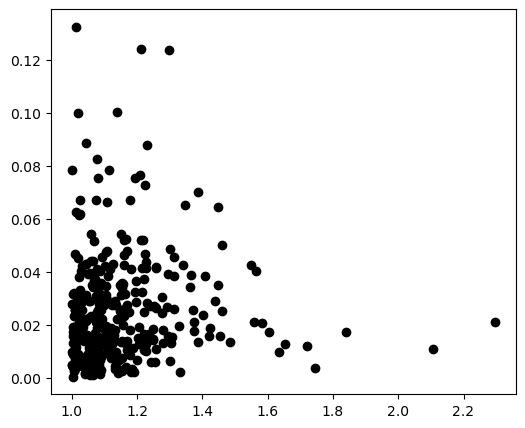

In [71]:
print(np.nanmin(vel),np.nanmax(vel))

fig = plt.figure(figsize=(6,5))
plt.plot(aux1,vel,'ko',linestyle='None')
plt.show()


In [ ]:

#w_nc_fid.mask_e3sm_all_regions = "1.NA SPSS, 2.NA STSS, 3.NA STPS, 4.AEQU, 5.SA STPS, 6.MED (not in FM14)" ;
#w_nc_fid.mask_e3sm_all_regions = "7.IND STPS, 8.(not in FM14)" ;
#w_nc_fid.mask_e3sm_all_regions = "9.NP SPSS, 10.NP STSS, 11.NP STPS, 12.PEQU-W, 13.PEQU-E, 14.SP STPS" ;
#w_nc_fid.mask_e3sm_all_regions = "15.ARCTIC ICE (not in FM14), 16.NP ICE, 17.NA ICE, 18.Barents (not in FM14)" ;
#w_nc_fid.mask_e3sm_all_regions = "19. STSS_Atl, 20. SPSS_Atl, 21. ICE_Atl, 22. STSS_Ind, 23. SPSS_Ind, 24. ICE_Ind, 25. STSS_Pac, 26. SPSS_Pac, 27. ICE_Pac"


#-----
# if there is a pattern in space: 
#
# for each large biome, get all floats that stay within that biome for a whole year
# get avg+std of the ratio of the seasonal amplitude (daily vs 10-day sampling)
#-----

# FOR NOW: only analyze tropical biomes -> where the model is eddy-permitting!

# only include those floats who stay within 21°S-21°N the whole year

    
# check if float is in eddy-permitting region the whole year
is_in_tropics = np.zeros(lat_all_E3SM_10.shape[1])
for ff in range(0,lat_all_E3SM_10.shape[1]):
    aux1 = lat_all_E3SM_10[:,ff]
    ind=np.where(~np.isnan(aux1))[0]
    aux1 = aux1[ind]
    if all(i >=-21 for i in aux1): # if all latitudes are north of 21°S
        if all(i <=21 for i in aux1): # if all latitudes are south of 21°N
            is_in_tropics[ff]=1
    del aux1,ind

fig = plt.figure(figsize=(18,7)) # x, y
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.set_extent([-179, 179, -90, 90])

for nn in tqdm(range(0,lon0.shape[0])):
    #if biome_all_10_start[nn] in [4,5,7,8,11,12,13,14]: # only plot floats in certain biomes
    if is_in_tropics[nn]==1:
        plt.scatter(lon0[nn], lat0[nn],c=no3_ampl_ratio[dd,nn],s=ms,vmin=1,vmax=1.1,cmap=plt.cm.RdYlBu_r,marker='o',transform=ccrs.PlateCarree())
    #plt.plot(lon0[nn], lat0[nn],color='darkblue', marker='o',markersize=ms,transform=ccrs.Geodetic())
    
plt.colorbar(orientation='vertical')

ax.yaxis.tick_left()
ax.set_xticks([-180,-120, -60, 0, 60, 120, 180],crs=ccrs.PlateCarree())
ax.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
    
#save_plots = False
#if save_plots:
#    dpicnt = 200
#    if plot_first_day:
#        #filename = 'Map_test_run_initial_float_positions.png'
#        filename = 'Map_run_6years_initial_float_positions_only_deepOcean.png'
#    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()
